# Выжившие на Титанике

Даны 2 набора данных: трейн и тест о пассажирах титаника. 

В трейне известна летальность. Нужно предсказать, сколько умерших в тесте. Метрика accuracy.

## Импорты

Работать будем с пандасом, бустингами, лесом и логрегом, т.к. задача бинарной классификации по типу "да/нет"

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


from sklearn.model_selection import train_test_split


/home/dgv/.local/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Предобработка

Посмотрим, что там у нас за данные:

In [2]:
train = pd.read_csv('train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test = pd.read_csv('test.csv')
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Таблица соотношений:

In [4]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Самому старому старику 80 лет. Интересно, он выживет?) 512 максимальное расстояние до выхода (если я правильно понимаб признак Fare) шагов или метров... В принципе, если в панике быстро бежать, то шаг - это как раз метр)

**Распределения ещё посмотрим на паре графиков:**

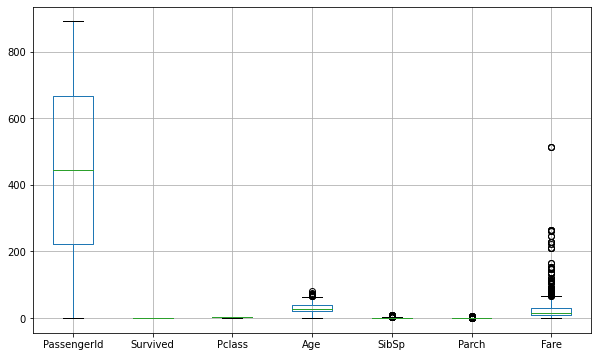

In [5]:
train.boxplot(figsize=(10,6))
plt.show()

/home/dgv/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


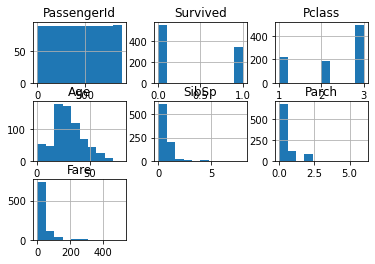

In [6]:
train.hist()
plt.show()

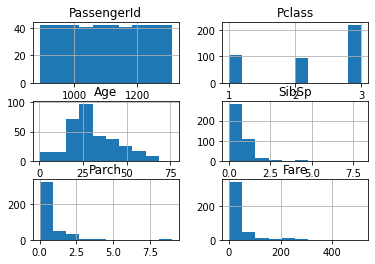

In [7]:
test.hist()
plt.show()

Ситуация, конечно, плохая с этим краблём получилась, труппов больше, чем выживших примерно в 2 раза, но думаю, что для обучения этого хватит и масштабирование признаков не понадобится.

Больше всего ехало бедняков 3-м классом, молодых, возрастом 20-30 лет в среднем. Вообще возраст стандартно распределён, на корабле,как и в жизни, так сказать )

Посмотрим на билеты:

- Некоторые билеты повторяются, оставим столбец, как признак

In [8]:
train['Ticket'].value_counts()

CA. 2343           7
347082             7
1601               7
347088             6
3101295            6
                  ..
350026             1
345767             1
SOTON/OQ 392090    1
364512             1
113059             1
Name: Ticket, Length: 681, dtype: int64

Там в кабинах сразу наны в таблице выдны, изучим столбец:

In [9]:
train['Cabin'].value_counts()

C23 C25 C27    4
G6             4
B96 B98        4
C22 C26        3
F2             3
              ..
B50            1
C62 C64        1
F G63          1
B86            1
C85            1
Name: Cabin, Length: 147, dtype: int64

Лучше посмотреть на это разнообразие через уникальные значения:

In [10]:
train['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

Похоже на классовое распределение кабин, можно применить классификацию: A, B, C, D, E, G, F и T.

Но для начала уберём пропуски, заменив их на другую классификацию (может это какие нибудь кабины для нищих или что-то в этом роде.

In [11]:
train['Cabin'] = train['Cabin'].fillna('other')

In [12]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,other,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,other,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,other,S


Добавим признак:

In [13]:
def cab_satus(row):
    if 'A' in row['Cabin']:
        return 'A'
    elif 'B' in row['Cabin']:
        return 'B'
    elif 'C' in row['Cabin']:
        return 'C'
    elif 'D' in row['Cabin']:
        return 'D'
    elif 'E' in row['Cabin']:
        return 'E'
    elif 'F' in row['Cabin']:
        return 'F'
    elif 'G' in row['Cabin']:
        return 'G'
    elif 'T' in row['Cabin']:
        return 'T'
    else:
        return 'other'
    
train['Cabin_stat'] = train.apply(cab_satus, axis=1)

In [14]:
train['Cabin_stat'].unique()

array(['other', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

И в тестовую сразу добавим, заодно наны из её кабин уберём:

In [15]:
test['Cabin'].unique()

array([nan, 'B45', 'E31', 'B57 B59 B63 B66', 'B36', 'A21', 'C78', 'D34',
       'D19', 'A9', 'D15', 'C31', 'C23 C25 C27', 'F G63', 'B61', 'C53',
       'D43', 'C130', 'C132', 'C101', 'C55 C57', 'B71', 'C46', 'C116',
       'F', 'A29', 'G6', 'C6', 'C28', 'C51', 'E46', 'C54', 'C97', 'D22',
       'B10', 'F4', 'E45', 'E52', 'D30', 'B58 B60', 'E34', 'C62 C64',
       'A11', 'B11', 'C80', 'F33', 'C85', 'D37', 'C86', 'D21', 'C89',
       'F E46', 'A34', 'D', 'B26', 'C22 C26', 'B69', 'C32', 'B78',
       'F E57', 'F2', 'A18', 'C106', 'B51 B53 B55', 'D10 D12', 'E60',
       'E50', 'E39 E41', 'B52 B54 B56', 'C39', 'B24', 'D28', 'B41', 'C7',
       'D40', 'D38', 'C105'], dtype=object)

In [16]:
test['Cabin'] = test['Cabin'].fillna('other')

In [17]:

test['Cabin_stat'] = test.apply(cab_satus, axis=1)
test['Cabin_stat'].unique()

array(['other', 'B', 'E', 'A', 'C', 'D', 'F', 'G'], dtype=object)

Посмотрим, чё там ещё с пропусками:

In [18]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin            0
Embarked         2
Cabin_stat       0
dtype: int64

In [19]:
test.isna().sum()

PassengerId     0
Pclass          0
Name            0
Sex             0
Age            86
SibSp           0
Parch           0
Ticket          0
Fare            1
Cabin           0
Embarked        0
Cabin_stat      0
dtype: int64

In [20]:
train['Age'].unique()

array([22.  , 38.  , 26.  , 35.  ,   nan, 54.  ,  2.  , 27.  , 14.  ,
        4.  , 58.  , 20.  , 39.  , 55.  , 31.  , 34.  , 15.  , 28.  ,
        8.  , 19.  , 40.  , 66.  , 42.  , 21.  , 18.  ,  3.  ,  7.  ,
       49.  , 29.  , 65.  , 28.5 ,  5.  , 11.  , 45.  , 17.  , 32.  ,
       16.  , 25.  ,  0.83, 30.  , 33.  , 23.  , 24.  , 46.  , 59.  ,
       71.  , 37.  , 47.  , 14.5 , 70.5 , 32.5 , 12.  ,  9.  , 36.5 ,
       51.  , 55.5 , 40.5 , 44.  ,  1.  , 61.  , 56.  , 50.  , 36.  ,
       45.5 , 20.5 , 62.  , 41.  , 52.  , 63.  , 23.5 ,  0.92, 43.  ,
       60.  , 10.  , 64.  , 13.  , 48.  ,  0.75, 53.  , 57.  , 80.  ,
       70.  , 24.5 ,  6.  ,  0.67, 30.5 ,  0.42, 34.5 , 74.  ])

Возраст, мы помним, распределён нормально, поэтому пропуски заполним средним значением.

In [21]:
mean_age = train['Age'].mean()

In [22]:
train['Age'] = train['Age'].fillna(mean_age)
train.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       2
Cabin_stat     0
dtype: int64

In [23]:
train['Age'].unique()

array([22.        , 38.        , 26.        , 35.        , 29.69911765,
       54.        ,  2.        , 27.        , 14.        ,  4.        ,
       58.        , 20.        , 39.        , 55.        , 31.        ,
       34.        , 15.        , 28.        ,  8.        , 19.        ,
       40.        , 66.        , 42.        , 21.        , 18.        ,
        3.        ,  7.        , 49.        , 29.        , 65.        ,
       28.5       ,  5.        , 11.        , 45.        , 17.        ,
       32.        , 16.        , 25.        ,  0.83      , 30.        ,
       33.        , 23.        , 24.        , 46.        , 59.        ,
       71.        , 37.        , 47.        , 14.5       , 70.5       ,
       32.5       , 12.        ,  9.        , 36.5       , 51.        ,
       55.5       , 40.5       , 44.        ,  1.        , 61.        ,
       56.        , 50.        , 36.        , 45.5       , 20.5       ,
       62.        , 41.        , 52.        , 63.        , 23.5 

In [24]:
test['Age'] = test['Age'].fillna(mean_age)
test.isna().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           1
Cabin          0
Embarked       0
Cabin_stat     0
dtype: int64

Ещё возраст лучше округлить

In [25]:
train['Age'] = train['Age'].astype('uint8')
test['Age'] = test['Age'].astype('uint8')

Не особо вникла, что это за признак, но 1 и 2 пропуска можно просто удалить

In [26]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [27]:
train = train.dropna()
train.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
Cabin_stat     0
dtype: int64

Видимо удалённость от выхода:

In [28]:
test['Fare'].value_counts()

7.7500     21
26.0000    19
8.0500     17
13.0000    17
7.8958     11
           ..
9.3250      1
14.4583     1
15.0333     1
25.4667     1
21.0750     1
Name: Fare, Length: 169, dtype: int64

In [29]:
test = test.dropna()
test.isna().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
Cabin_stat     0
dtype: int64

Вынесем уникальные номера пассажиров в индексы таблиц:

In [30]:
train.set_index('PassengerId', inplace=True)
train.head(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_stat
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,other,S,other
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,other,S,other


In [31]:
test.set_index('PassengerId', inplace=True)
test.head(3)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_stat
PassengerId,,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34,0,0,330911,7.8292,other,Q,other
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47,1,0,363272,7.0000,other,S,other
894,2,"Myles, Mr. Thomas Francis",male,62,0,0,240276,9.6875,other,Q,other


In [32]:
train['Ticket'].unique()

array(['A/5 21171', 'PC 17599', 'STON/O2. 3101282', '113803', '373450',
       '330877', '17463', '349909', '347742', '237736', 'PP 9549',
       '113783', 'A/5. 2151', '347082', '350406', '248706', '382652',
       '244373', '345763', '2649', '239865', '248698', '330923', '113788',
       '347077', '2631', '19950', '330959', '349216', 'PC 17601',
       'PC 17569', '335677', 'C.A. 24579', 'PC 17604', '113789', '2677',
       'A./5. 2152', '345764', '2651', '7546', '11668', '349253',
       'SC/Paris 2123', '330958', 'S.C./A.4. 23567', '370371', '14311',
       '2662', '349237', '3101295', 'A/4. 39886', 'PC 17572', '2926',
       '113509', '19947', 'C.A. 31026', '2697', 'C.A. 34651', 'CA 2144',
       '2669', '36973', '347088', 'PC 17605', '2661', 'C.A. 29395',
       'S.P. 3464', '3101281', '315151', 'C.A. 33111', 'S.O.C. 14879',
       '2680', '1601', '348123', '349208', '374746', '248738', '364516',
       '345767', '345779', '330932', '113059', 'SO/C 14885', '3101278',
       'W./C

Думаю, что с таким количеством уникальных значений билеты, как и имена пассажиров в обучении модели участвовать не будут.

**Посмотрим-ка ещё раз на нашу "причёсанную" таблицу:**

In [33]:
train.info()
train.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 1 to 891
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    889 non-null    int64  
 1   Pclass      889 non-null    int64  
 2   Name        889 non-null    object 
 3   Sex         889 non-null    object 
 4   Age         889 non-null    uint8  
 5   SibSp       889 non-null    int64  
 6   Parch       889 non-null    int64  
 7   Ticket      889 non-null    object 
 8   Fare        889 non-null    float64
 9   Cabin       889 non-null    object 
 10  Embarked    889 non-null    object 
 11  Cabin_stat  889 non-null    object 
dtypes: float64(1), int64(4), object(6), uint8(1)
memory usage: 84.2+ KB


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_stat
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,other,S,other
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,other,S,other


In [34]:
test.info()
test.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417 entries, 892 to 1309
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      417 non-null    int64  
 1   Name        417 non-null    object 
 2   Sex         417 non-null    object 
 3   Age         417 non-null    uint8  
 4   SibSp       417 non-null    int64  
 5   Parch       417 non-null    int64  
 6   Ticket      417 non-null    object 
 7   Fare        417 non-null    float64
 8   Cabin       417 non-null    object 
 9   Embarked    417 non-null    object 
 10  Cabin_stat  417 non-null    object 
dtypes: float64(1), int64(3), object(6), uint8(1)
memory usage: 36.2+ KB


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_stat
PassengerId,,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34,0,0,330911,7.8292,other,Q,other
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47,1,0,363272,7.0000,other,S,other
894,2,"Myles, Mr. Thomas Francis",male,62,0,0,240276,9.6875,other,Q,other


Отлично :) Выглядит хорошо.

## Разбивка на цели/признаки

Создавая признаки избавимся заодно от "груза" по типу уникальных значений имён пользователей и билетов, хватит и индексов, чтоб потом всё вернуть на место.

In [35]:
target_train = train['Survived'] #конечно же цель - определить выживание
features_train = train.drop(['Name', 'Ticket', 'Survived'], axis=1)

In [36]:
features_test = test.drop(['Name', 'Ticket'], axis=1)

In [37]:
features_train.head(3) #проверка

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Cabin_stat
PassengerId,,,,,,,,,
1,3,male,22,1,0,7.2500,other,S,other
2,1,female,38,1,0,71.2833,C85,C,C
3,3,female,26,0,0,7.9250,other,S,other


Разобьём трейн на трейн и валид, что б понять, насколько хороши наши модели.

In [38]:
 features_train, features_valid, target_train, target_valid = train_test_split(features_train, target_train, test_size=0.3, random_state=12345)

Обычно под валид выделяют 30%/

In [39]:
"Соотношение тренировочной к тестовой выборке:", target_train.shape, target_valid.shape

('Соотношение тренировочной к тестовой выборке:', (622,), (267,))

## Анализ моделей

### Логистическая регрессия

Придётся сделать прямое кодирование, она буквы не читает.

In [40]:
features_train_ohe = pd.get_dummies(features_train.drop(['Cabin', 'Cabin_stat'], axis=1), drop_first=True)

features_train_ohe.info()
features_train_ohe.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 622 entries, 63 to 484
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      622 non-null    int64  
 1   Age         622 non-null    uint8  
 2   SibSp       622 non-null    int64  
 3   Parch       622 non-null    int64  
 4   Fare        622 non-null    float64
 5   Sex_male    622 non-null    uint8  
 6   Embarked_Q  622 non-null    uint8  
 7   Embarked_S  622 non-null    uint8  
dtypes: float64(1), int64(3), uint8(4)
memory usage: 26.7 KB


,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
PassengerId,,,,,,,,
63,1,45,1,0,83.4750,1,0,1
498,3,29,0,0,15.1000,1,0,1
572,1,53,2,0,51.4792,0,0,1
386,2,18,0,0,73.5000,1,0,1
879,3,29,0,0,7.8958,1,0,1


In [41]:
features_valid_ohe = pd.get_dummies(features_valid.drop(['Cabin', 'Cabin_stat'], axis=1), drop_first=True)

features_valid_ohe.head(3)

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
PassengerId,,,,,,,,
689,3,18,0,0,7.7958,1,0,1
785,3,25,0,0,7.0500,1,0,1
551,1,17,0,2,110.8833,1,0,0


Тест тоже заодно изменим, вдруг логрег станет лучшей моделью:

In [42]:
features_test_ohe = pd.get_dummies(features_test.drop(['Cabin', 'Cabin_stat'], axis=1), drop_first=True)

features_test_ohe.head(3)

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
PassengerId,,,,,,,,
892,3,34,0,0,7.8292,1,1,0
893,3,47,1,0,7.0000,0,0,1
894,2,62,0,0,9.6875,1,1,0


Пришлось удалить некоторые признаки, т.к. при прямом кодировании столбцов получается неодинаковое количество и модели не работают.

**Создадим модель:**

In [43]:
model_log = LogisticRegression(random_state=12345, solver='liblinear')
model_log.fit(features_train_ohe, target_train)
predicted_log_valid = model_log.predict(features_valid_ohe)

print("Предсказание несбалансированной модели:", model_log.score(features_valid_ohe, target_valid))
print("Accuracy:", accuracy_score(target_valid, predicted_log_valid))
print("F1:", f1_score(target_valid, predicted_log_valid))

Предсказание несбалансированной модели: 0.8052434456928839
Accuracy: 0.8052434456928839
F1: 0.7204301075268816


### Модель леса

In [44]:
best_model_forest = None
best_result_forest = 0
best_predict_forest = None

for est in range(1, 50):
    for depth in range(1, 12):
        model_forest = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) # обучим модель с заданным количеством деревьев
        model_forest.fit(features_train_ohe, target_train) # обучим модель на тренировочной выборке
        result_forest = model_forest.score(features_valid_ohe, target_valid) # посчитаем качество модели на валидационной выборке
        predict_forest = model_forest.predict(features_valid_ohe)

        if result_forest > best_result_forest:
            best_model_forest = model_forest # сохраним наилучшую модель
            best_result_forest = result_forest #  сохраним наилучшее значение метрики accuracy на валидационных данных
            best_predict_forest = predict_forest

print("Accuracy наилучшей модели случайного леса на валидационной выборке:", best_result_forest)
print("F1:", f1_score(target_valid, best_predict_forest))

Accuracy наилучшей модели случайного леса на валидационной выборке: 0.8389513108614233
F1: 0.7724867724867724


Кстати тут мы не используем гридсёрч, потому что он меня бесит своей медлительностью. Лучше использовать библиотеку рандомного подбора `Optuna`, но её мы тоже использовать не будем, т.к. это кагловский конкурс, а с оптуной кагл не дружит. Пусть будет обычный цикл.

### CatBoost

Для этого зверя нужно определить столбцы-категории, высчитать индексы этих столбцов. Капец как неудобно, но что поделать.

In [45]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 622 entries, 63 to 484
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      622 non-null    int64  
 1   Sex         622 non-null    object 
 2   Age         622 non-null    uint8  
 3   SibSp       622 non-null    int64  
 4   Parch       622 non-null    int64  
 5   Fare        622 non-null    float64
 6   Cabin       622 non-null    object 
 7   Embarked    622 non-null    object 
 8   Cabin_stat  622 non-null    object 
dtypes: float64(1), int64(3), object(4), uint8(1)
memory usage: 44.3+ KB


Вот слева от столбцов их индексы.

In [46]:
cat_features_list = [1, 6, 7, 8] #это мы передадим в параметры модели

In [47]:
model_cat = CatBoostClassifier(iterations=70, cat_features=cat_features_list, random_seed=12345)

Посчитаем время и важность признаков заодно:

In [48]:
%%timeit
model_cat.fit(features_train, target_train, verbose=10)

Learning rate set to 0.096367
0:	learn: 0.6591639	total: 74ms	remaining: 5.1s
10:	learn: 0.4863845	total: 146ms	remaining: 783ms
20:	learn: 0.4279062	total: 211ms	remaining: 493ms
30:	learn: 0.4057665	total: 251ms	remaining: 316ms
40:	learn: 0.3860942	total: 298ms	remaining: 211ms
50:	learn: 0.3741312	total: 344ms	remaining: 128ms
60:	learn: 0.3660245	total: 393ms	remaining: 58ms
69:	learn: 0.3579647	total: 435ms	remaining: 0us
Learning rate set to 0.096367
0:	learn: 0.6591639	total: 5.18ms	remaining: 358ms
10:	learn: 0.4863845	total: 26.3ms	remaining: 141ms
20:	learn: 0.4279062	total: 48.7ms	remaining: 114ms
30:	learn: 0.4057665	total: 64ms	remaining: 80.5ms
40:	learn: 0.3860942	total: 95.2ms	remaining: 67.3ms
50:	learn: 0.3741312	total: 112ms	remaining: 41.9ms
60:	learn: 0.3660245	total: 126ms	remaining: 18.6ms
69:	learn: 0.3579647	total: 146ms	remaining: 0us
Learning rate set to 0.096367
0:	learn: 0.6591639	total: 1.64ms	remaining: 113ms
10:	learn: 0.4863845	total: 19.2ms	remaining:

In [49]:
predicted_valid_cat = model_cat.predict(features_valid)
print("accuracy модели catboost:", accuracy_score(target_valid, predicted_valid_cat))
print("f1 модели catboost:", f1_score(target_valid, predicted_valid_cat))

accuracy модели catboost: 0.797752808988764
f1 модели catboost: 0.6966292134831461


Затраченное время для вычисления важности: 0.001 секунд


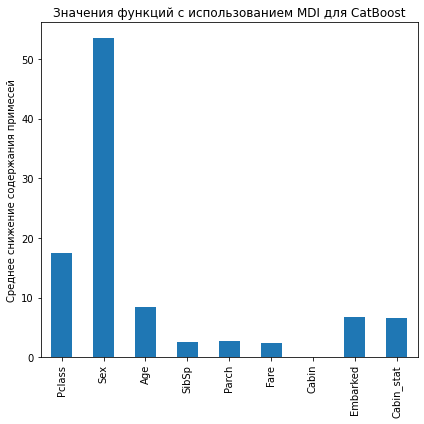

In [50]:
start_time = time.time()
importances_cat_valid = model_cat.feature_importances_
std = np.std([
    model_cat.feature_importances_], axis=0)
elapsed_time = time.time() - start_time

print(f"Затраченное время для вычисления важности: "
      f"{elapsed_time:.3f} секунд")

cat_importances_valid = pd.Series(importances_cat_valid, index=features_valid.columns)

fig, ax = plt.subplots(figsize=(6, 6))
cat_importances_valid.plot.bar(yerr=std, ax=ax)
ax.set_title("Значения функций с использованием MDI для CatBoost")
ax.set_ylabel("Среднее снижение содержания примесей")
fig.tight_layout()

### LightGBM

Нужно определить категориальные столбцы для этой модели

In [51]:
features_train[
    ['Sex', 
     'Cabin', 
     'Embarked',  
     'Cabin_stat']
] = features_train[
    ['Sex', 
     'Cabin', 
     'Embarked',  
     'Cabin_stat']
].astype('category')

features_valid[
    ['Sex', 
     'Cabin', 
     'Embarked',  
     'Cabin_stat']
] = features_valid[
    ['Sex', 
     'Cabin', 
     'Embarked',  
     'Cabin_stat']
].astype('category')

features_test[
    ['Sex', 
     'Cabin', 
     'Embarked',  
     'Cabin_stat']
] = features_test[
    ['Sex', 
     'Cabin', 
     'Embarked',  
     'Cabin_stat']
].astype('category')

In [52]:
model_gbm = LGBMClassifier(random_state=12345, class_weight='balanced')

In [53]:
%%timeit
model_gbm.fit(features_train, target_train, verbose=10)

192 ms ± 83.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [54]:
predicted_valid_gbm = model_gbm.predict(features_valid)
print("accuracy модели LGBM:", accuracy_score(target_valid, predicted_valid_gbm))
print("f1 модели LGBM:", f1_score(target_valid, predicted_valid_gbm))

accuracy модели LGBM: 0.7940074906367042
f1 модели LGBM: 0.7120418848167538


### Вывод

В общем лучше всех моделей справилась модель случайного леса. Её и будем использовать. Градиентный бустинг проиграл :))

## Получение предсказаний на тестовых признаках!

Хорошим тоном будет объединение выборок обратно в одну большую тестовую.

In [55]:
features_train_valid = pd.concat([features_train_ohe, features_valid_ohe])
target_train_valid = pd.concat([target_train, target_valid])

Обучим модель леса на случайной выборке и получим предсказания.

In [56]:
best_model_forest.fit(features_train_valid, target_train_valid)
predicted_test = best_model_forest.predict(features_test_ohe)


Теперь перенесём в сериес предсказания

In [57]:
predict = pd.Series(predicted_test)


Вернём индекс в столбец таблицы (так нужно по условию проекта)

In [58]:
test = test.rename_axis('PassengerId').reset_index()
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_stat
0,892,3,"Kelly, Mr. James",male,34,0,0,330911,7.8292,other,Q,other
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47,1,0,363272,7.0000,other,S,other
2,894,2,"Myles, Mr. Thomas Francis",male,62,0,0,240276,9.6875,other,Q,other
3,895,3,"Wirz, Mr. Albert",male,27,0,0,315154,8.6625,other,S,other
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22,1,1,3101298,12.2875,other,S,other
...,...,...,...,...,...,...,...,...,...,...,...,...
412,1305,3,"Spector, Mr. Woolf",male,29,0,0,A.5. 3236,8.0500,other,S,other
413,1306,1,"Oliva y Ocana, Dona. Fermina",female,39,0,0,PC 17758,108.9000,C105,C,C
414,1307,3,"Saether, Mr. Simon Sivertsen",male,38,0,0,SOTON/O.Q. 3101262,7.2500,other,S,other
415,1308,3,"Ware, Mr. Frederick",male,29,0,0,359309,8.0500,other,S,other


вынесем нумеровку пассажиров как сериес (мы будем делать итоговую таблицу).

In [59]:
passenger = test['PassengerId']
passenger

0       892
1       893
2       894
3       895
4       896
       ... 
412    1305
413    1306
414    1307
415    1308
416    1309
Name: PassengerId, Length: 417, dtype: int64

Подготовим словарик для нашей итоговой таблицы:

In [60]:

data = {
    'PassengerId': passenger, 
    'Survived': predict
}

А теперь создадим, наконец-то, таблицу

In [61]:
df = pd.DataFrame(data=data)
df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
412,1305,0
413,1306,1
414,1307,0
415,1308,0


И выведем её наружу из тетради)

In [62]:

df.to_csv(r'predict.csv')